# CS Project 175 Phase 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np

from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn import metrics 
from sklearn import preprocessing
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords


import seaborn

## Building the Pipeline

In [4]:
RANDOM_STATE = 42

def gather_data():
    # data = pd.read_csv('./data/data.csv')
    data = pd.read_csv('/content/drive/MyDrive/data/data.csv')
    return data['lyrics'], data['genre']

def vectorize_labels(labels, classes=None):
    '''
    Vectorizes the labels.
    Returns as (indexes, labels)
    '''
    if classes is None:
        return pd.factorize(labels)
    return pd.Categorical(labels, categories=classes).codes, classes


# PHASE 1 START ----------------------------------------------------------------
def features_bow(data):
    vectorizer = CountVectorizer(stop_words='english', min_df=0.01, ngram_range=(1, 2))
    text = data.to_list()
    X = vectorizer.fit_transform(text)
    return X, vectorizer

def train_model_logistic(X, Y):
    classifier = linear_model.LogisticRegression(penalty='l2', multi_class='multinomial', class_weight='balanced', random_state=RANDOM_STATE, fit_intercept=True)
    classifier.fit(X, Y)
    return classifier

def evaluate_model_logistic(model, X_train, Y_train, X_test, Y_test):
    train_accuracy = model.score(X_train, Y_train)
    print('\nTraining:')
    print(' accuracy:',format( 100*train_accuracy , '.2f') ) 

    # Compute and print accuracy on the test data
    print('\nTesting: ')
    test_accuracy = model.score(X_test, Y_test)
    print(' accuracy:', format( 100*test_accuracy , '.2f') )

    # Compute and print AUC on the test data
    class_probabilities = model.predict_proba(X_test)
    test_auc_score = metrics.roc_auc_score(Y_test, class_probabilities, multi_class='ovo')
    print(' AUC value:', format( 100*test_auc_score , '.2f') )
    

def evaluate_model_sklearn(model, X_train, Y_train, X_test, Y_test):
    train_accuracy = model.score(X_train, Y_train)
    print('\nTraining:')
    print(' accuracy:',format( 100*train_accuracy , '.2f') ) 

    # Compute and print accuracy on the test data
    print('\nTesting: ')
    test_accuracy = model.score(X_test, Y_test)
    print(' accuracy:', format( 100*test_accuracy , '.2f') )

    # Compute and print AUC on the test data
    class_probabilities = model.predict_proba(X_test)
    test_auc_score = metrics.roc_auc_score(Y_test, class_probabilities, multi_class='ovo')
    print(' AUC value:', format( 100*test_auc_score , '.2f') )
# PHASE 1 END ------------------------------------------------------------------

# PHASE 2 START ----------------------------------------------------------------
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

def train_model_mlp(X, Y, solver='lbfgs', **kwargs):
    classifier = MLPClassifier(solver=solver, random_state=RANDOM_STATE, **kwargs)
    classifier.fit(X, Y)
    return classifier
    
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import os

def features_word2vec(data):
    word_lists = data.str.split()
    if not os.path.exists("word2vec.wordvectors"):
        print("Did not find pre-trained embeddings, training now...")
        model = Word2Vec(sentences=word_lists, vector_size=200, window=5, min_count=1, workers=4)
        word_vectors = model.wv
        word_vectors.save("word2vec.wordvectors")
    else:
        print("Found pre-trained embeddings, loading now...")
        word_vectors = KeyedVectors.load("word2vec.wordvectors", mmap='r')
    print("Vectorizing features...")
    res = []
    i = 0
    for word_list in word_lists:
        sub = []
        for word in word_list:
            if word in word_vectors:
                sub.append(word_vectors[word])
        res.append(sub)
        if i % 1000 == 0:
            print(i, "/", len(word_lists))
        i += 1
    return res

def clean_vectors(X, Y):
    # remove inputs with too few vectors
    small_inputs = [i for i, x in enumerate(X) if len(x) < 10]
    small_inputs_set = set(small_inputs)
    X = [v for i, v in enumerate(X) if i not in small_inputs_set]
    Y = np.delete(Y, small_inputs)
    return X, Y

def train_model_rnn(X, Y):
    pass

def evaluate_model_rnn(model, X_train, Y_train, X_test, Y_test):
    pass

# PHASE 2 END ------------------------------------------------------------------

## Executing the Pipeline

In [5]:
# Phase 2 pipeline
inputs, labels = gather_data()

In [6]:
x = np.array(inputs)
y = np.array(labels)
x.shape

(295242,)

In [7]:
red = [i for i in range(y.shape[0]) if y[i] in ['rock', 'pop']]


In [8]:
new_x = pd.Series(np.delete(x, red))
new_y = pd.Series(np.delete(y, red))

In [9]:
from collections import Counter
freq = (dict(Counter(new_y)))
s = sum(freq.values())
freq = dict(map(lambda x: (x[0],x[1]/s), freq.items()))
print(freq)

{'metal': 0.3468684279296656, 'hip-hop': 0.16554461852437188, 'jazz': 0.23502034619644346, 'folk': 0.15760524645652635, 'r&b': 0.09496136089299269}


In [10]:
# convert to classes
Y, classes = vectorize_labels(new_y)
# convert to features
X, vectorizer = features_bow(new_x)

In [11]:
X_bow_train, X_bow_test, Y_bow_train, Y_bow_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)

In [12]:
logistic = train_model_logistic(X_bow_train,Y_bow_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [13]:
evaluate_model_sklearn(logistic, X_bow_train, Y_bow_train, X_bow_test, Y_bow_test)


Training:
 accuracy: 72.14

Testing: 
 accuracy: 68.45
 AUC value: 88.42


In [16]:
mlp = train_model_mlp(X_bow_train, Y_bow_train)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [17]:
evaluate_model_sklearn(mlp, X_bow_train, Y_bow_train, X_bow_test, Y_bow_test)


Training:
 accuracy: 98.82

Testing: 
 accuracy: 71.33
 AUC value: 86.95


In [ ]:
mlp1 = train_model_mlp(X_bow_train, Y_bow_train, max_iter=500)

In [ ]:
evaluate_model_sklearn(mlp1, X_bow_train, Y_bow_train, X_bow_test, Y_bow_test)

In [18]:
nn = train_model_mlp(X_bow_train, Y_bow_train, solver='sgd', hidden_layer_sizes=(1000,500))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [19]:
evaluate_model_sklearn(nn, X_bow_train, Y_bow_train, X_bow_test, Y_bow_test)


Training:
 accuracy: 98.53

Testing: 
 accuracy: 74.00
 AUC value: 89.24


In [20]:
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report



In [21]:
def cross_validation(model, _X, _y, folds=5):
    '''Function to perform 5 Folds Cross-Validation
    Parameters
    ----------
    model: Python Class, default=None
          This is the machine learning algorithm to be used for training.
    _X: array
       This is the matrix of features.
    _y: array
       This is the target variable.
    folds: int, default=5
      Determines the number of folds for cross-validation.
    Returns
    -------
    The function returns a dictionary containing the metrics 'accuracy', 'precision',
    'recall', 'f1' for both training set and validation set.
    '''
    score_method = ['accuracy']
    results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=folds,
                               scoring=score_method,
                               return_train_score=True)
    return results
    
    
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, validation_data):
    '''Function to plot a grouped bar chart showing the training and validation
      results of the ML model in each fold after applying K-fold cross-validation.
     Parameters
     ----------
     x_label: str, 
        Name of the algorithm used for training e.g 'Decision Tree'

     y_label: str, 
        Name of metric being visualized e.g 'Accuracy'
     plot_title: str, 
        This is the title of the plot e.g 'Accuracy Plot'

     train_data: list, array
        This is the list containing either training precision, accuracy, or f1 score.

     validation_data: list, array
        This is the list containing either validation precision, accuracy, or f1 score.
     Returns
     -------
     The function returns a Grouped Barchart showing the training and validation result
     in each fold.
    '''

    # Set size of plot
    plt.figure(figsize=(12,6))
    labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
    X_axis = np.arange(len(labels))
    ax = plt.gca()
    plt.ylim(0.40000, 1)
    plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
    plt.bar(X_axis+0.2, validation_data, 0.4, color='red', label='Validation')
    plt.title('5-Fold Accuracy', fontsize=30)
    plt.xticks(X_axis, labels)
    plt.xlabel('Folds', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()
        
def classification_adv_metrics(model, X, Y):
    y_pred = model.predict(X)
    return classification_report(Y, y_pred, target_names=classes)

In [22]:
# # train model
# model = train_model_rnn(X_train, Y_train)

## Evaluating the Model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


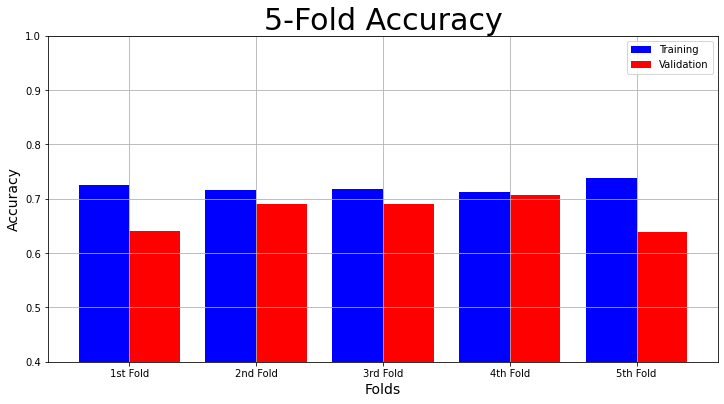

In [23]:
logistic_res = cross_validation(logistic, X, Y)
plot_result('folds', 'accuracy', 'Accuracy 5-fold Train/Test', logistic_res['train_accuracy'], logistic_res['test_accuracy'])

In [24]:
print(np.mean(logistic_res['train_accuracy']))
print(np.mean(logistic_res['test_accuracy']))
print(np.mean(np.hstack((logistic_res['train_accuracy'], logistic_res['test_accuracy']))))

0.7216117179785712
0.6735395646168063
0.6975756412976888


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

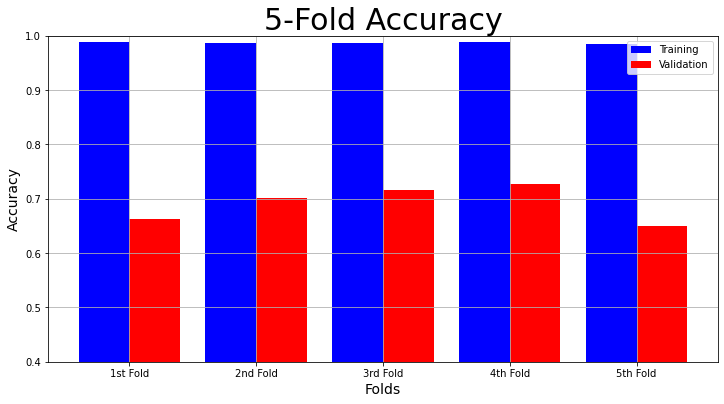

In [25]:
mlp_res = cross_validation(mlp, X, Y)
plot_result('folds', 'accuracy', 'Accuracy 5-fold Train/Test', mlp_res['train_accuracy'], mlp_res['test_accuracy'])

In [26]:
print(np.mean(mlp_res['train_accuracy']))
print(np.mean(mlp_res['test_accuracy']))
print(np.mean(np.hstack((mlp_res['train_accuracy'], mlp_res['test_accuracy']))))

0.9868651971230802
0.6915710481663948
0.8392181226447375


In [ ]:
nn_res = cross_validation(nn, X, Y)
plot_result('folds', 'accuracy', 'Accuracy 5-fold Train/Test', nn_res['train_accuracy'], nn_res['test_accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
print(np.mean(nn_res['train_accuracy']))
print(np.mean(nn_res['test_accuracy']))
print(np.mean(np.hstack((nn_res['train_accuracy'], nn_res['test_accuracy']))))